# k- Nearest Neighbor (KNN)



k-vecinos más próximos es un algoritmo sencillo el cual guarda todos los posibles casos y clasifica los nuevos datos de acuerdo a sus vecinos.

$k = $ Número de vecinos más cercanos al nuevo dato. i.e. si $k = 5$ entonces buscamos a los 5 vecinos más cercanos del dato que queremos clasificar.

Usualmente se toma $k = \{ 3, \ldots, 10 \}$

Un valor muy pequeño de $k$ implica que el ruido en los datos puede tener más importancia en los resultados.

Un valor muy grande de $k$ hace al modelo caro, computacionalmente hablando.


**Pasos:**

1. Definir cómo se va a medir la distancia.
2. Seleccionar los $k$ elementos más cercanos al nuevo dato.
3. La clase/categoría con más puntos dentro de los $k$ seleccionados será la clase/categoría del nuevo dato.


In [1]:
# Se cargan las librerías que se van a utilizar
import math
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import mlxtend
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)

from matplotlib import cm
from matplotlib.colors import ListedColormap, BoundaryNorm
from mlxtend.plotting import plot_decision_regions
from sklearn import metrics
from sklearn import neighbors, datasets
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Se carga la base de datos
# Los datos pueden encontrarse en diferentes formatos, en este caso están en un txt.
df = pd.read_table('fruit_data_with_colors.txt')
print(df.shape) #Se tienen 59 renglones y 7 columnas

(59, 7)


In [3]:
## 2) ANÁLISIS EXPLORATORIO
# Se realiza una descripción analítica de los datos.
df.head(10)# Se muestran los primeros 10 datos del data frame

,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
0,1,apple,granny_smith,192,8.4,7.3,0.55
1,1,apple,granny_smith,180,8.0,6.8,0.59
2,1,apple,granny_smith,176,7.4,7.2,0.60
3,2,mandarin,mandarin,86,6.2,4.7,0.80
4,2,mandarin,mandarin,84,6.0,4.6,0.79
5,2,mandarin,mandarin,80,5.8,4.3,0.77
6,2,mandarin,mandarin,80,5.9,4.3,0.81
7,2,mandarin,mandarin,76,5.8,4.0,0.81
8,1,apple,braeburn,178,7.1,7.8,0.92
9,1,apple,braeburn,172,7.4,7.0,0.89


Los datos corresponden a 59 frutas con 7 características:

   - **fruit_label:** Etiqueta de la fruta
   - **fruit_name:** Nombre de la fruta = orange, apple, mandarin, lemon
   - **fruit_subtype:** Subtipo de fruta = braeburn, cripps_pink, golden_delicious, granny_smith, mandarin selected_seconds, spanish_belsan, spanish_jumbo, turkey_navel, unknown.
   - **mass:** Masa de la fruta
   - **width:** Ancho de la fruta
   - **height:** Altura de la fruta
   - **color_score:** Calificación del color: [calif](https://i.stack.imgur.com/Dmpz3.png)
   
Cabe aclarar que la base de datos corresponde a frutas de E.U.A. por lo que en algunos casos los pesos y medidas no corresponden a los promedios de las frutas mexicanas. Las principales diferencias las encontramos en las mandarinas y los limones.


[Mandarinas](https://i.redd.it/5uja5in1iei01.jpg)

[Lime = Limón verde, Lemon = Limón amarillo](https://i.ytimg.com/vi/hV841oL5tNE/hqdefault.jpg)


In [4]:
#Nos indica el tipo de dato que tiene cada columna
df.dtypes

fruit_label        int64
fruit_name        object
fruit_subtype     object
mass               int64
width            float64
height           float64
color_score      float64
dtype: object

In [5]:
# Se cuenta el número de NaN's por columna
df.isnull().sum() #No hay columnas con NaN

fruit_label      0
fruit_name       0
fruit_subtype    0
mass             0
width            0
height           0
color_score      0
dtype: int64

In [6]:
# Con la función "describe()" se obtiene un resumen estadístico de las columnas con valores numéricos.
df.describe()

,fruit_label,mass,width,height,color_score
count,59.000000,59.000000,59.000000,59.000000,59.000000
mean,2.542373,163.118644,7.105085,7.693220,0.762881
std,1.208048,55.018832,0.816938,1.361017,0.076857
min,1.000000,76.000000,5.800000,4.000000,0.550000
25%,1.000000,140.000000,6.600000,7.200000,0.720000
50%,3.000000,158.000000,7.200000,7.600000,0.750000
75%,4.000000,177.000000,7.500000,8.200000,0.810000
max,4.000000,362.000000,9.600000,10.500000,0.930000


De la tabla anterior podemos extraer la siguiente información:

   - Se tienen 4 tipos de frutas (viendo la columna _fruit_label_)
   - En promedio las frutas pesan 163 unidades de masa (g, kg, lb,...)
   - El ancho de las frutas va desde 5.8 unidades de medida, hasta 9.6 (cm,in,...)
   - Se puede decir que el puntaje del color está en $[0,1]$

In [7]:
# Se imprimen los 4 tipos de fruta que se tienen en el data frame:
print('Los tipos de fruta son: ',df['fruit_name'].unique())

Los tipos de fruta son:  ['apple' 'mandarin' 'orange' 'lemon']


In [8]:
# Se imprime el número de elementos que tiene cada fruta:
print(df.groupby('fruit_name').size())

fruit_name
apple       19
lemon       16
mandarin     5
orange      19
dtype: int64


Hay 19 manzanas, 16 limones amarillos, 5 mandarinas y 19 naranjas.

In [9]:
# Se imprime el número de elementos que tiene cada subtipo de fruta:
print(df.groupby('fruit_subtype').size())

fruit_subtype
braeburn             5
cripps_pink          6
golden_delicious     5
granny_smith         3
mandarin             5
selected_seconds     6
spanish_belsan       6
spanish_jumbo        3
turkey_navel        10
unknown             10
dtype: int64


In [10]:
# Se definen las varibles X (predictoras) y Y (dependiente)
feature_names = ['mass', 'width', 'height', 'color_score']
X = df[feature_names]
Y = df['fruit_label']
print(type(X))
X.head()

<class 'pandas.core.frame.DataFrame'>


,mass,width,height,color_score
0,192,8.4,7.3,0.55
1,180,8.0,6.8,0.59
2,176,7.4,7.2,0.60
3,86,6.2,4.7,0.80
4,84,6.0,4.6,0.79


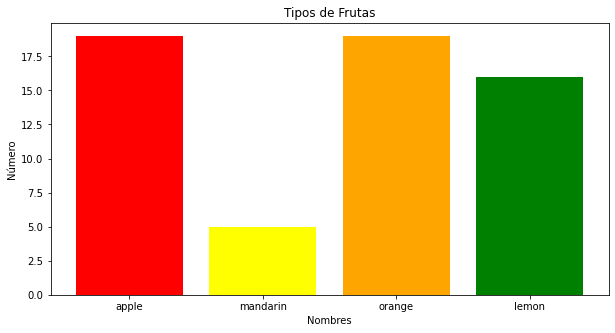

In [11]:
## 3) VISUALIZACIÓN DE LOS DATOS
# Para entender mejor los datos es necesario graficarlos.
vec_colores = ['r','yellow','orange','green']

#Gráfica por tipo de fruta
plt.bar(df['fruit_name'].unique(),df.groupby(df['fruit_name'],sort = False).size(),color = vec_colores)
plt.title('Tipos de Frutas')
plt.xlabel('Nombres')
plt.ylabel('Número')
plt.show()

Se tiene la misma cantidad de naranjas que de manzanas.

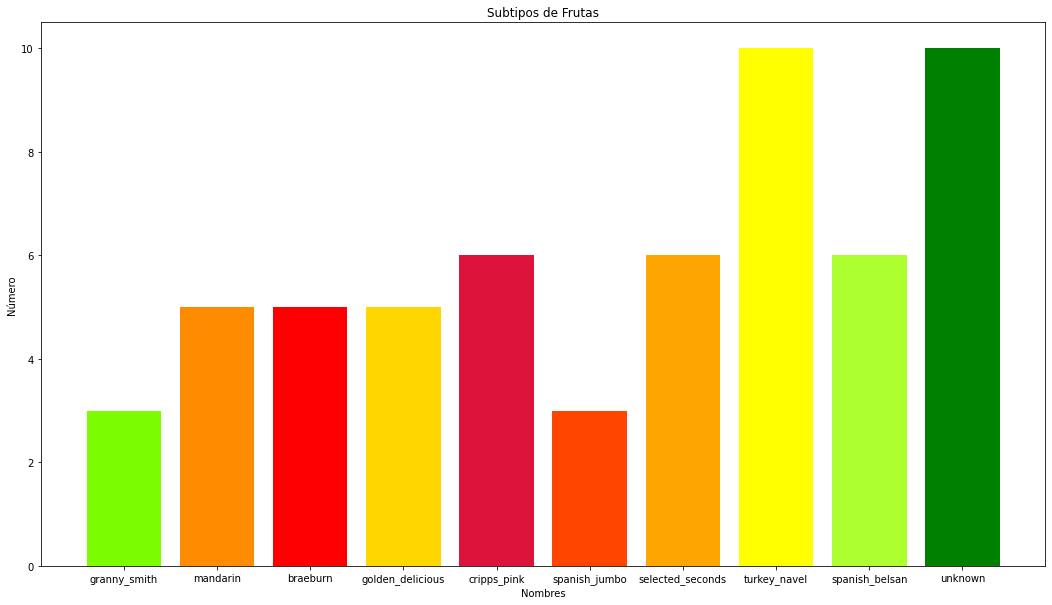

In [12]:
#Gráfica por subtipo de fruta
plt.subplots(figsize=(18,10)) #Se fija el tamaño de la figura (ancho,alto)
plt.bar(df['fruit_subtype'].unique(),df.groupby(df['fruit_subtype'],sort = False).size(),
        color = ['lawngreen','darkorange','red','gold','crimson','orangered','orange','yellow','greenyellow','green'])
plt.title('Subtipos de Frutas')
plt.xlabel('Nombres')
plt.ylabel('Número')
plt.show()

Los subtipos de frutas con más elementos son _turkey_navel_ que pertenecen a las naranjas y _unknown_ que pertenecen a una clase desconocida de limones amarillos.

Text(0, 0.5, 'Masa')

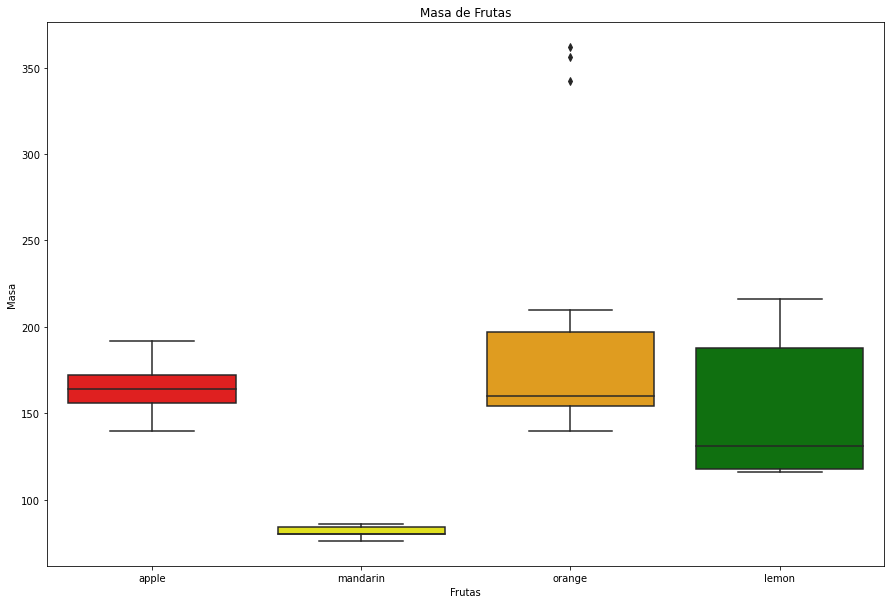

In [13]:
#Boxplot    
plt.figure(figsize=(15,10))
sns.boxplot(x='fruit_name',y='mass',data=df, palette=vec_colores)
plt.title('Masa de Frutas')
plt.xlabel('Frutas')
plt.ylabel('Masa')

Text(0, 0.5, 'Ancho')

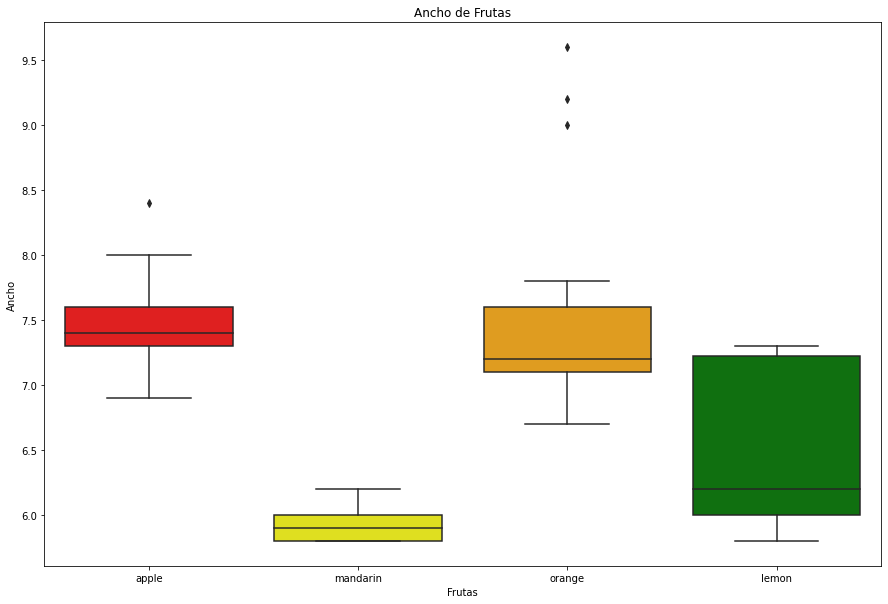

In [14]:
plt.figure(figsize=(15,10))
sns.boxplot(x='fruit_name',y='width',data=df, palette=vec_colores)
plt.title('Ancho de Frutas')
plt.xlabel('Frutas')
plt.ylabel('Ancho')

Text(0, 0.5, 'Altura')

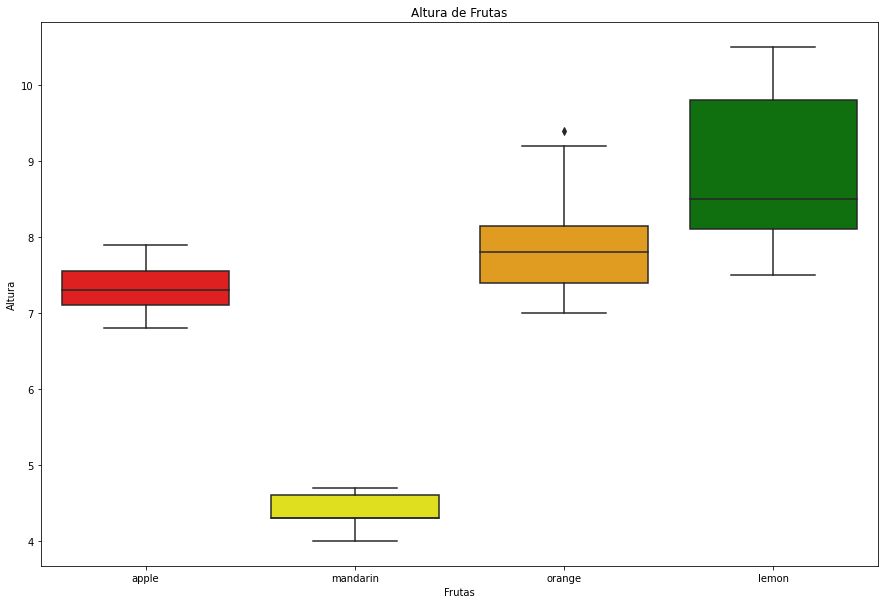

In [15]:
plt.figure(figsize=(15,10))
sns.boxplot(x='fruit_name',y='height',data=df, palette=vec_colores)
plt.title('Altura de Frutas')
plt.xlabel('Frutas')
plt.ylabel('Altura')

Text(0, 0.5, 'Calificación de color')

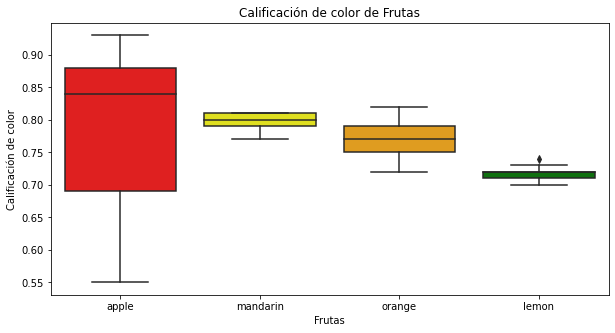

In [16]:
sns.boxplot(x='fruit_name',y='color_score',data=df, palette=vec_colores)
plt.title('Calificación de color de Frutas')
plt.xlabel('Frutas')
plt.ylabel('Calificación de color')

En cada cuadro se muestran las gráficas de caja por tipo de fruta.

Al ver los cuadros correspondientes a la masa, altura y ancho de cada fruta, vemos que las mandarinas son las frutas con menor masa, menor altura y se puede considerar que son las frutas menos anchas. Por lo tanto las mandarinas con las frutas más pequeñas.

En el primer cuadro vemos que el limón es la fruta con el mayor rango en cuanto a masa.

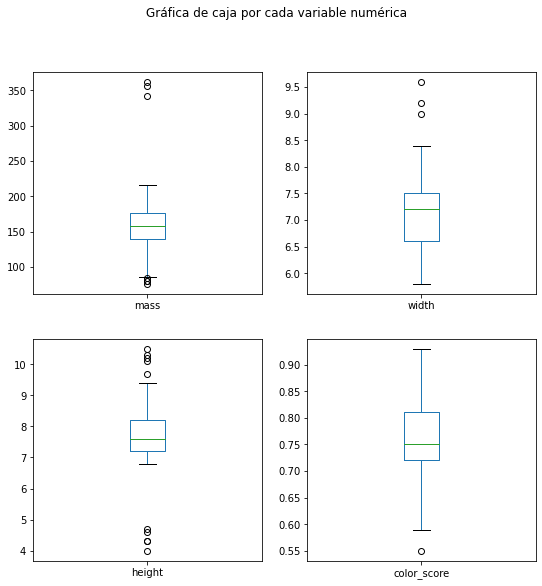

In [17]:
# Se muestran las gráficas de caja por masa, ancho, altura y puntaje de color
df.drop('fruit_label', axis=1).plot(kind='box', subplots=True, layout=(2,2),
                                    sharex=False, sharey=False, figsize=(9,9), 
                                    title='Gráfica de caja por cada variable numérica')
plt.show()

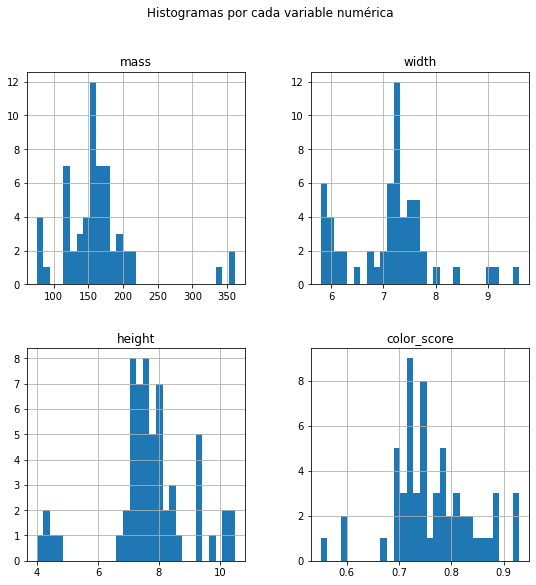

In [18]:
# Se muestran los Histogramas por masa, ancho, altura y puntaje de color
df.drop('fruit_label' ,axis=1).hist(bins=30, figsize=(9,9))
plt.suptitle("Histogramas por cada variable numérica")
plt.show()

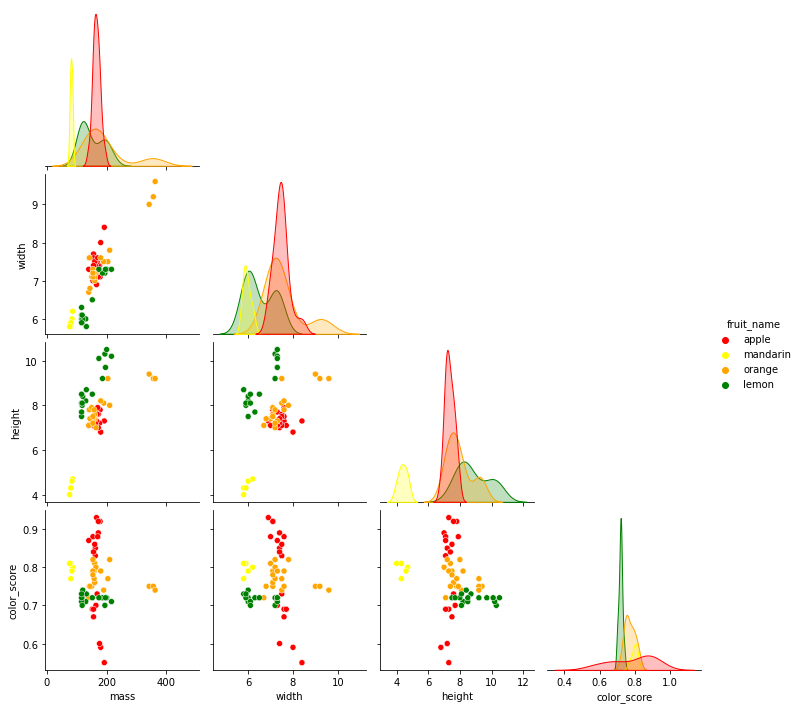

In [19]:
#Se muestra la correlación entre las variables
#sns.pairplot(df, hue="fruit_name", palette=vec_colores, diag_kind="hist", corner=True)
sns.pairplot(df.drop('fruit_label', axis=1), hue="fruit_name", palette=vec_colores, diag_kind="kde", corner=True)

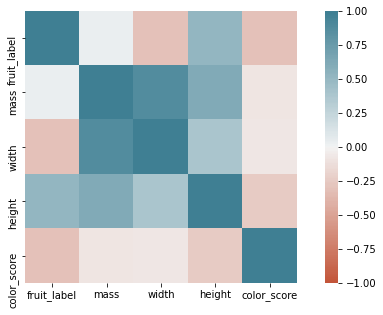

In [20]:
# Matriz de correlación
corr = df.corr()
#corr
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

**Masa vs ancho:**

Podemos observar que hay una correlación lineal entre la masa y el ancho de las frutas.

Al observar los puntos que se encuentran entre 100 y 300 unidades de masa, vemos que hay 3 tipos de fruta (manzana, naranja, limón).

**Ancho vs altura:**

En esta gráfica se puede ver con mayor claridad la diferencia entre las frutas.

**Masa vs altura:**

Entre mayor es la masa, mayor es la altura, por lo que existe una correlación lineal entre la masa y la altura de las frutas.

In [21]:
## 4) DIVIDIR LOS DATOS
# Se separan los datos en 2 grupos (usualmente 80% y 20%):
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size = 0.2,
                                                    random_state = 0)

In [22]:
# Se normalizan los datos
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

([<matplotlib.axis.XTick at 0x1a919ac5790>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

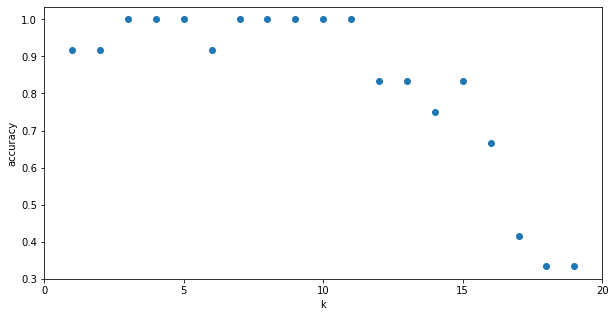

In [23]:
## 5) CONSTRUIR UN MODELO
# Para definir el parámetro "k", se van a hacer varias pruebas con k = {1,...,20}.
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, Y_train)
    scores.append(knn.score(X_test, Y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])

Con la gráfica anterior podemos decir que se obtiene el mayor porcentaje en la tasa de certeza cuando $k \in \{3, 4, 5, 7, 8, 9, 10, 11\}$.

Por lo tanto definimos $k = 3$.

In [24]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=3)

In [25]:
## 6) PREDICCIONES
# Se hacen las predicciones con "X_test"
Y_pred = knn.predict(X_test)

In [26]:
Y_pred

array([3, 3, 4, 3, 1, 1, 3, 4, 3, 1, 2, 1], dtype=int64)

In [27]:
## 7) EVALUACIÓN DEL MODELO
print('Score = ',round(knn.score(X_train, Y_train) * 100, 2),
      '% = Tasa de respuestas correctas del modelo en el conjunto de entrenamiento')
print('Accuracy = ',round(metrics.accuracy_score(Y_test, Y_pred) * 100, 2),
      '% = Tasa de respuestas correctas del modelo en el conjunto de prueba')

Score =  97.87 % = Tasa de respuestas correctas del modelo en el conjunto de entrenamiento
Accuracy =  100.0 % = Tasa de respuestas correctas del modelo en el conjunto de prueba


In [28]:
#Matriz de Confusión
print(confusion_matrix(Y_test, Y_pred))

[[4 0 0 0]
 [0 1 0 0]
 [0 0 5 0]
 [0 0 0 2]]


La tasa de respuestas correctas en el conjunto de prueba es del $100\%$ por lo que el modelo elegido predice sin errores.

Es por ello que la matriz de confusión únicamente tiene valores en la diagonal principal.

Ahora grafiquemos las regiones de decisión con _plot_decision_regions_.

Los datos tienen más de 2 variables explicativas por lo que tomamos únicamente 2 para poder graficar en 2D.

Tomamos ancho y altura.

In [29]:
X2 = df[['width','height']]
X2 = np.asarray(X2)
Y2 = np.asarray(Y)

knn2 = KNeighborsClassifier()
knn2.fit(X2, Y2)
knn #k = 3

KNeighborsClassifier(n_neighbors=3)

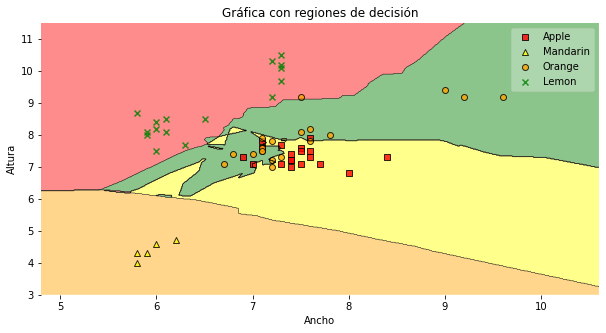

In [30]:
ax = plot_decision_regions(X2,Y2, clf=knn2, legend=2,
                           colors='r,yellow,orange,green')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['Apple', 'Mandarin', 'Orange', 'Lemon'],
          framealpha=0.3, scatterpoints=1)
plt.title('Gráfica con regiones de decisión')
plt.xlabel('Ancho')
plt.ylabel('Altura')
plt.show()

Tenemos 4 tipos de frutas por lo que hay 4 colores para las regiones de acuerdo a la clasificación.

La región roja corresponde a los limones amarillos.

La región verde corresponde a las naranjas.

La región amarilla corresponde a las manzanas.

La región naranja corresponde a las mandarinas.


Al observar los puntos que se encuentran entre 5 y 8 unidades de medida, vemos que hay 2 tipos de fruta: manzana y naranja. En esta zona no hay una división clara para la clasificación de las frutas.

# Conclusiones

El modelo elegido con $k = 3$ predice sin errores la clasificación de las frutas.

Para la predicción se tomaron en cuenta únicamente las variables numéricas: masa, ancho, altura y calificación del color.